X.shape = torch.Size([60000, 256])
X.shape = torch.Size([60000])
tensor([ 1,  0, -3, -7, -6,  0,  3,  6, -3,  0])
time: 0.6930692195892334


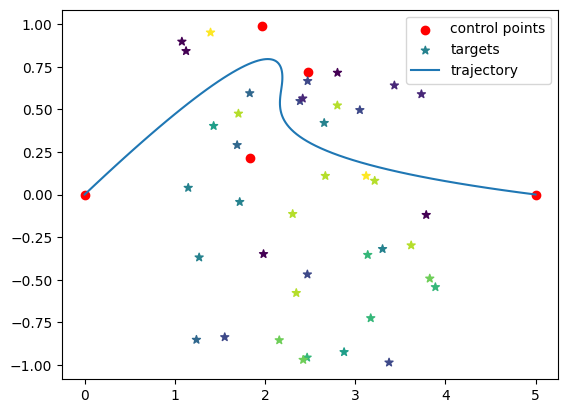

In [114]:
import torch
import matplotlib.pyplot as plt
from src import splev, evaluate
import numpy as np
import agent

P = 3
N_CTPS = 5
N_TARGETS = 40
N_CLASSES = 10
RADIUS = 0.3

# To understand what a trajectory looks like,
# let's generate a B-Spline of degree P with N control points from (0,0) to (N_CTPS,0).
# Note that a (clamped) B-Spline passes through its first and last control points.

t = torch.linspace(0, N_CTPS-P, 100)
knots = torch.cat([
    torch.zeros(P), 
    torch.arange(N_CTPS+1-P), 
    torch.full((P,), N_CTPS-P),
])

data0 = torch.load('./data.pth')
X = data0['feature']
y = data0['label']
print(f'X.shape = {X.shape}')
print(f'X.shape = {y.shape}')
X_train = X[:48000]
y_train = y[:48000]
X_test = X[48000:]
y_test = y[48000:]
a = agent.Agent()
feature = X_test[:40,:]
class_scores = torch.randint(-N_CLASSES, N_CLASSES, (N_CLASSES,))
target_pos = torch.rand((N_TARGETS, 2)) * torch.tensor([N_CTPS-2, 2.]) + torch.tensor([1., -1.])
y_pred = a.myModel.forward(feature)
y_predicted_cls = y_pred.argmax(1)
ctps = a.get_action(target_pos,feature,class_scores)
ctps_inter = torch.Tensor([[0,0],[1.9660, 0.9859],
        [2.4804, 0.7167],
        [1.8332, 0.2132],[5,0]])
traj = splev(t, knots, ctps_inter, P)

# Generate N_TARGETS targets
# essentially the same as `generate_game` function provided

plt.scatter(*ctps_inter.T, color="red", label="control points")   #画红点
plt.scatter(*target_pos.T, c=y_predicted_cls, marker="*", label="targets")
plt.plot(*traj.T, label="trajectory")   #画曲线
# plt.ylim(-1, 1) #把y轴规定在-1~1
plt.legend()    #图例

In [169]:
import random
a = torch.Tensor([[0],[1]])
b = torch.Tensor([[6,5],[4,7]])
c = torch.cat((b,a),1)
print(c)
d= torch.sort(c,descending=False,dim=1)
d.values

tensor([[6., 5., 0.],
        [4., 7., 1.]])


tensor([[0., 5., 6.],
        [1., 4., 7.]])

In [ ]:
# evaluate the trajectory by checking which targets does it hit
# # your goal is to choose ctps[1:-1] so that the score is maximized
# score = evaluate(traj, target_pos, target_scores, RADIUS)
# print(score)
# print(ctps)
# P_t = []
# for tt in t:
#     # P_t.append((ctps[1] * (1-tt)**2 / 2 + ctps[2] * (tt - tt**2 + 0.5) + ctps[3] * tt **2 / 2).numpy().tolist())
#     # P_t.append((ctps[0] * (1-tt)**3 / 6 + ctps[1] * (tt**3/2 - tt**2 + 2/3) + ctps[2] * ((tt + 1)**3 / 6 - 2 * tt ** 3 /3) + ctps[3] *(tt**3/6)).numpy().tolist())
#     # P_t.append((ctps[1] * (1-tt)**3 / 6 + ctps[2] * (tt**3/2 - tt**2 + 2/3) + ctps[3] * ((tt + 1)**3 / 6 - 2 * tt ** 3 /3) + ctps[4] *(tt**3/6)).numpy().tolist())
#     P_t.append((ctps[0] * (1-tt)**4 / 24 + ctps[1] * (tt**3 / 2 - tt**2/4 - tt/2 - tt**4/6 + 11/24) + ctps[2] * ((tt + 2)**4 / 24 - (5 * (tt+1)**4 / 24) + 5*tt**4 /12) + ctps[3] *((tt+1)**4/24 - 5*tt**4/24) + ctps[4] * (tt**4/24)).numpy().tolist())
# mytraj = torch.tensor(P_t)
# plt.scatter(*mytraj.T, color="blue", label="hhh")


In [1]:
import multiprocess as mp
mp.cpu_count()

8

In [110]:

x = torch.atleast_1d(t)
u = (torch.searchsorted(knots, x)-1).clip(3, 5-1).unsqueeze(-1)
x = x.unsqueeze(-1)
d = ctps[u-3+torch.arange(4)].contiguous()
plt.scatter(*d.T, color="blue", label="hhh")
for r in range(1, 3+1):
    j = torch.arange(r-1, 3) + 1
    t0 = knots[j+u-3]
    t1 = knots[j+u+1-r]
    alpha = ((x - t0) / (t1 - t0)).unsqueeze(-1)
    d[:, j] = (1-alpha)*d[:, j-1] + alpha*d[:, j]
a = d[:, 3]
plt.scatter(*a.T, color="green", label="hhh")
plt.ylim(-1,1)


NameError: name 't' is not defined

In [26]:
import torch
data0 = torch.load('./data.pth')
X = data0['feature']
y = data0['label']
print(f'X.shape = {X.shape}')
print(f'X.shape = {y.shape}')

X.shape = torch.Size([60000, 256])
X.shape = torch.Size([60000])


In [27]:
from src import generate_game, N_CTPS, evaluate, compute_traj, RADIUS
from agent import Agent

epoch = 500
n_targets = 40
agent = Agent()
target_pos, target_features, target_cls, class_scores = generate_game(n_targets, N_CTPS, X, y)
print(f'target_pos: {target_pos.shape}\ntarget_features: {target_features.shape}\ntarget_cls: {target_cls.shape}\nclass_scores: {class_scores.shape}')


target_pos: torch.Size([40, 2])
target_features: torch.Size([40, 256])
target_cls: torch.Size([40])
class_scores: torch.Size([10])


In [39]:
input = torch.cat((target_pos, torch.unsqueeze(class_scores[target_cls],1)),1)
# print(f'input.shape: {input.shape}')
# print(input)
# print(ctps[..., 1:, :] - ctps[..., :-1, :])
print(ctps)
print(knots)
n = ctps.size(-2)
ctps = (ctps[..., 1:, :]-ctps[..., :-1, :])/(knots[1+1:1+n]-knots[1:n]).unsqueeze(-1)
ctps

tensor([[   -inf,    -inf],
        [ 0.0000,  0.0508],
        [ 0.1250, -0.5287]])
tensor([0., 0., 0., 0., 1., 2., 2., 2., 2.])


tensor([[inf, inf],
        [inf, -inf]])

In [40]:
import agent
import torch

data0 = torch.load('./data.pth')
X = data0['feature']
y = data0['label']
print(f'X.shape = {X.shape}')
print(f'X.shape = {y.shape}')
X_train = X[:48000]
y_train = y[:48000]
X_test = X[48000:]
y_test = y[48000:]
    

X.shape = torch.Size([60000, 256])
X.shape = torch.Size([60000])


In [73]:
import matplotlib.pyplot as plt
from src import splev, evaluate
import numpy as np
P = 3
N_CLASSES = 10
N_TARGETS = 20
N_CTPS = 5
RADIUS = 0.3
a = agent.Agent()
feature = X_test[:20,:]
class_scores = torch.randint(-N_CLASSES, N_CLASSES, (N_CLASSES,))
target_pos = torch.rand((N_TARGETS, 2)) * torch.tensor([N_CTPS-2, 2.]) + torch.tensor([1., -1.])

ctps = a.get_action(target_pos,feature,class_scores)
y_pred = a.myModel.forward(feature)
y_predicted_cls = y_pred.argmax(1)
lr = 1
target_scores = class_scores[y_predicted_cls]
positive_target = target_pos[target_scores >= 0]
positive_score = target_scores[target_scores >= 0]
print(target_pos)
print(target_scores)
print(positive_target)
print(positive_score)

tensor([[ 1.4461,  0.6549],
        [ 2.9648, -0.7750],
        [ 3.7325,  0.2604],
        [ 1.6632,  0.6472],
        [ 1.5849,  0.4067],
        [ 3.7857,  0.7324],
        [ 1.4542,  0.7653],
        [ 3.1500,  0.6380],
        [ 3.4596, -0.0383],
        [ 3.2771, -0.3046],
        [ 3.4492, -0.4626],
        [ 3.9866,  0.9909],
        [ 2.7508,  0.7409],
        [ 3.3347,  0.9453],
        [ 2.9446,  0.6693],
        [ 1.9148,  0.8483],
        [ 3.2263, -0.9750],
        [ 2.0591,  0.0281],
        [ 3.2475,  0.3605],
        [ 3.8799,  0.3844]])
tensor([-6,  1,  2,  2,  0,  3,  3,  2, -6, -6,  1,  2, -8, -6, -2, -6,  0, -6,
        -6, -6])
tensor([[ 2.9648, -0.7750],
        [ 3.7325,  0.2604],
        [ 1.6632,  0.6472],
        [ 1.5849,  0.4067],
        [ 3.7857,  0.7324],
        [ 1.4542,  0.7653],
        [ 3.1500,  0.6380],
        [ 3.4492, -0.4626],
        [ 3.9866,  0.9909],
        [ 3.2263, -0.9750]])
tensor([1, 2, 2, 0, 3, 3, 2, 1, 2, 0])


In [2]:
import torch
N_CTPS = 5
a = torch.tensor([[[0., 0.]],[[0., 0.]],[[0., 0.]]])
c = torch.rand((3, N_CTPS-2, 2)) * torch.tensor([N_CTPS-2, 2.]) + torch.tensor([1., -1.])
b = torch.tensor([[[N_CTPS, 0.]],[[N_CTPS, 0.]],[[N_CTPS, 0.]]])
print(a)
print(c[0])
torch.cat((a,c,b),dim=1)


tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
tensor([[ 1.6924, -0.3755],
        [ 3.7506,  0.3024],
        [ 1.9623,  0.6023]])


tensor([[[ 0.0000,  0.0000],
         [ 1.6924, -0.3755],
         [ 3.7506,  0.3024],
         [ 1.9623,  0.6023],
         [ 5.0000,  0.0000]],

        [[ 0.0000,  0.0000],
         [ 1.2502,  0.7225],
         [ 1.8574, -0.5054],
         [ 3.9068,  0.9775],
         [ 5.0000,  0.0000]],

        [[ 0.0000,  0.0000],
         [ 2.1406, -0.0897],
         [ 2.1673, -0.0731],
         [ 3.3873, -0.0822],
         [ 5.0000,  0.0000]]])

In [47]:
x = torch.randn(2,4, 3, 2)
# x_1 = torch.randn(3, 1, 2) * torch.tensor([0.,0.])
# y = torch.cat((x_1,x), dim=1)
# y_1 = torch.cat((x, x, x), dim=1)
# y_2 = torch.cat((x, x, x), dim=2)
x = torch.tensor([[[0., 0.]]]*5)

x

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])

In [21]:
def sigmoid(d:torch.Tensor):
    return 1. / (1 + torch.exp(40* (d-0.3)))

d = torch.Tensor([0.25,0.3,0.35])
sigmoid(d)

tensor([0.8808, 0.5000, 0.1192])

In [1]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report

class MLP(nn.Module):
    def __init__(self, n_i, n_h_1, n_h_2, n_o):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(n_i, n_h_1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(n_h_1, n_h_2)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(n_h_2,n_o)
    def forward(self, input):
        return self.linear3(self.relu(self.linear2(self.relu(self.linear1(self.flatten(input))))))



In [2]:
data0 = torch.load('./data.pth')
X = data0['feature']
y = data0['label']
print(f'X.shape = {X.shape}')
print(f'X.shape = {y.shape}')
X_train = X[:48000]
y_train = y[:48000]
X_test = X[48000:]
y_test = y[48000:]

X.shape = torch.Size([60000, 256])
X.shape = torch.Size([60000])


In [11]:
num_epochs = 1500
learning_rate = 0.1 
models = MLP(X_train.shape[1],X_train.shape[1] // 2,X_train.shape[1] // 4 ,len(torch.unique(y_train)))
criterions = torch.nn.CrossEntropyLoss()
optimizers = torch.optim.SGD(models.parameters(), lr=learning_rate)

In [12]:
for epoch in range(num_epochs):
    models.train()
    optimizers.zero_grad()
    # Forward pass
    y_pred  = models(X_train)
    # Compute Loss
    loss = criterions(y_pred, y_train)
    # Backward pass
    loss.backward()
    optimizers.step()
    if (epoch+1) % 100 == 0:                                         
        # printing loss values on every 10 epochs to keep track
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 100, loss = 0.2362
epoch: 200, loss = 0.1585
epoch: 300, loss = 0.2029
epoch: 400, loss = 0.0953
epoch: 500, loss = 0.0778
epoch: 600, loss = 0.0653
epoch: 700, loss = 0.0950
epoch: 800, loss = 0.0670
epoch: 900, loss = 0.0539
epoch: 1000, loss = 0.0449
epoch: 1100, loss = 0.0377
epoch: 1200, loss = 0.0323
epoch: 1300, loss = 0.0279
epoch: 1400, loss = 0.0239
epoch: 1500, loss = 0.0207


In [13]:
with torch.no_grad():
    logits = models(X_test)
    y_pred = torch.nn.Softmax(dim=1)(logits)
    y_predicted_cls = y_pred.argmax(1)
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')
print(classification_report(y_test, y_predicted_cls))

accuracy: 0.9695
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1194
           1       0.99      0.99      0.99      1272
           2       0.96      0.96      0.96      1196
           3       0.96      0.96      0.96      1242
           4       0.98      0.97      0.98      1187
           5       0.97      0.94      0.95      1097
           6       0.97      0.98      0.98      1170
           7       0.96      0.97      0.97      1297
           8       0.96      0.97      0.96      1198
           9       0.96      0.96      0.96      1147

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



In [14]:
torch.save(models.state_dict(),'./Classify_Model_2.pth')